# Flood Sensor Data Analysis using Unsupervised Learning
This notebook explores unsupervised learning techniques to analyze flood sensor data patterns and support flood model improvement.

## Goals:
1. Identify natural patterns in flood behavior
2. Detect anomalous flood events
3. Group similar flood patterns
4. Reduce dimensionality for model input
5. Support model parameter optimization

In [14]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)

In [15]:
# Load and preprocess data
def load_flood_data(filepath):
    # Read the CSV file
    df = pd.read_csv(filepath)
    
    # Convert timestamp to datetime
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)
    
    return df

# Load the data
df = load_flood_data('flood_sensor_data_Zhang.csv')
print("Data shape:", df.shape)
df.head()

Data shape: (291, 13)


,fs-00070,fs-00071,fs-00077,fs-00083,fs-00101,fs-00073,fs-00100,fs-00096,fs-00049,fs-00048,fs-00047,fs-00032,fs-00031
Time,,,,,,,,,,,,,
2023-09-29 00:00:00,0.0,0.001667,0.000000,0.0,0.001616,0.002184,0.0,0.001914,0.005368,0.001408,0.0,0.332212,0.002923
2023-09-29 00:05:00,0.0,0.001191,0.000000,0.0,0.002843,0.002407,0.0,0.001770,0.004406,0.000956,0.0,0.333371,0.003016
2023-09-29 00:10:00,0.0,0.001021,0.000000,0.0,0.002423,0.002500,0.0,0.001671,0.005411,0.000523,0.0,0.334520,0.003376
2023-09-29 00:15:00,0.0,0.001623,0.000121,0.0,0.001178,0.003007,0.0,0.001475,0.006206,0.000427,0.0,0.340833,0.003563
2023-09-29 00:20:00,0.0,0.001555,0.000276,0.0,0.000928,0.003774,0.0,0.001323,0.006397,0.001076,0.0,0.354836,0.003297


## 1. Temporal Pattern Analysis using K-means Clustering

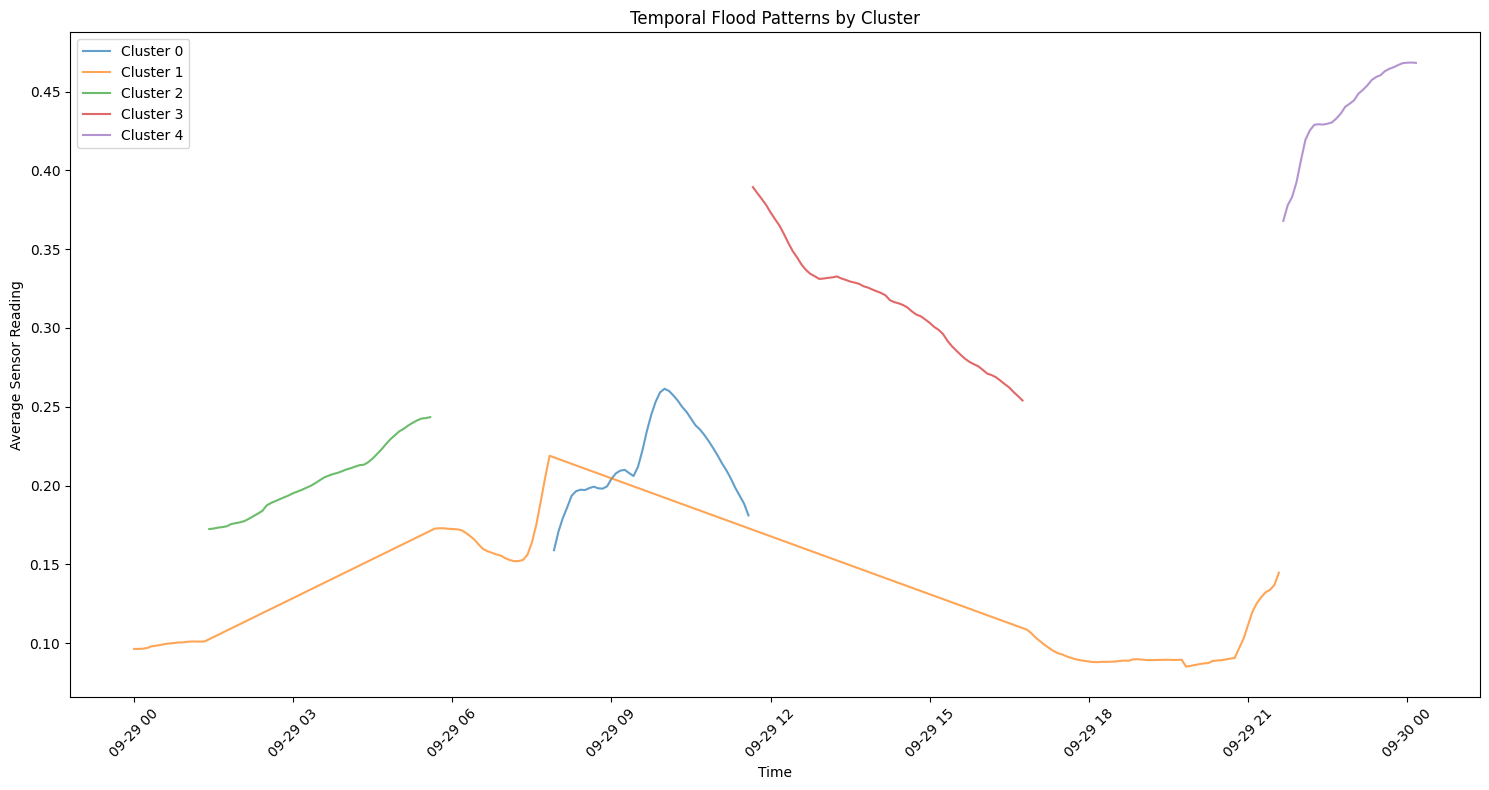

In [16]:
def analyze_temporal_patterns(df, n_clusters=5):
    # Prepare data for clustering
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_data)
    
    # Add cluster labels to dataframe
    df_clustered = df.copy()
    df_clustered['Cluster'] = clusters
    
    # Visualize cluster patterns
    plt.figure(figsize=(15, 8))
    for i in range(n_clusters):
        cluster_data = df_clustered[df_clustered['Cluster'] == i]
        plt.plot(cluster_data.index, cluster_data.mean(axis=1), 
                 label=f'Cluster {i}', alpha=0.7)
    
    plt.title('Temporal Flood Patterns by Cluster')
    plt.xlabel('Time')
    plt.ylabel('Average Sensor Reading')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return df_clustered, kmeans

# Analyze temporal patterns
df_clustered, kmeans_model = analyze_temporal_patterns(df)

## 2. Anomaly Detection using Elliptic Envelope

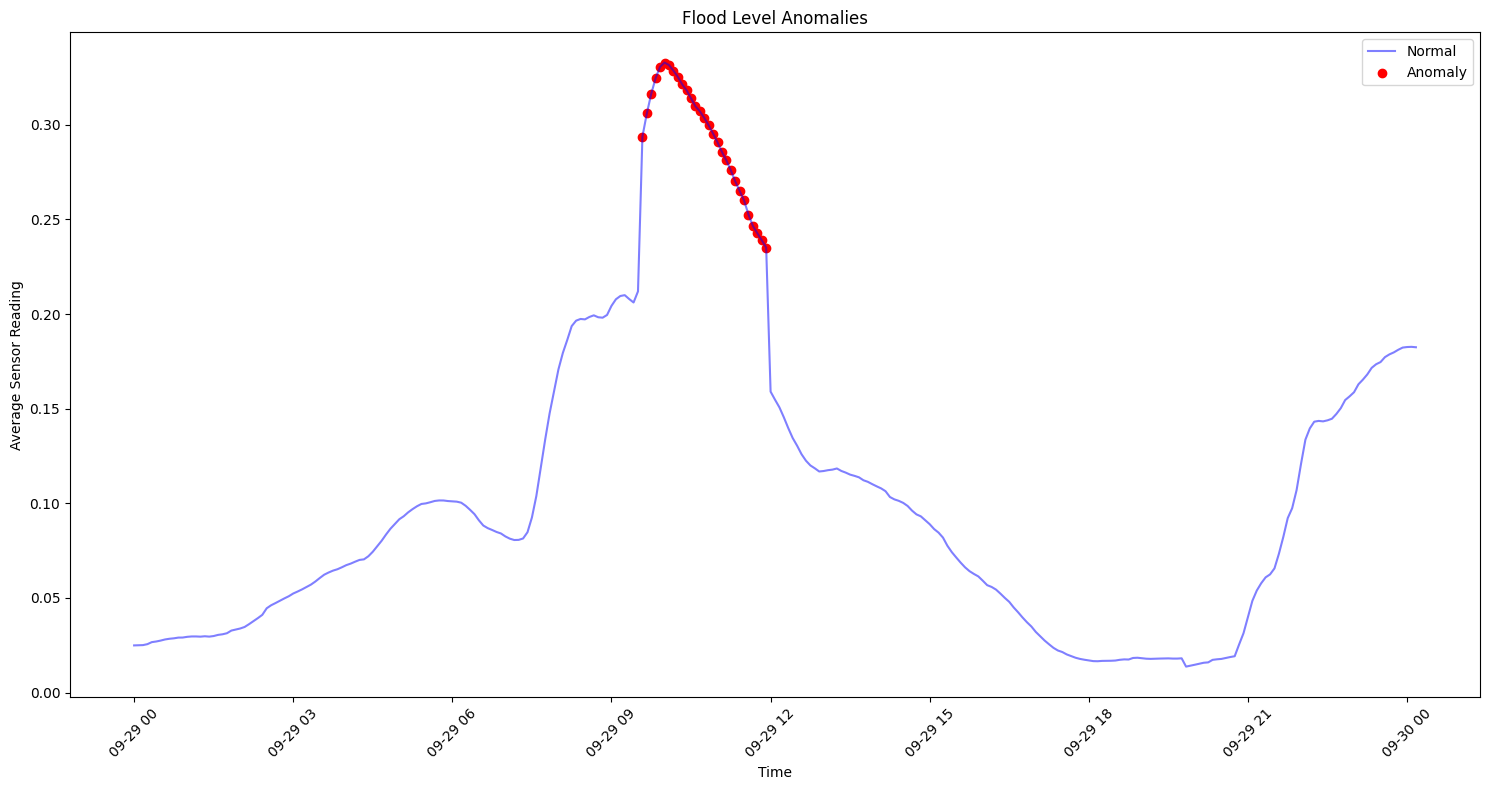

In [17]:
def detect_anomalies(df, contamination=0.1):
    # Prepare data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    
    # Apply Elliptic Envelope for anomaly detection
    detector = EllipticEnvelope(contamination=contamination, random_state=42)
    anomalies = detector.fit_predict(scaled_data)
    
    # Add anomaly labels to dataframe
    df_anomalies = df.copy()
    df_anomalies['Is_Anomaly'] = anomalies == -1
    
    # Visualize anomalies
    plt.figure(figsize=(15, 8))
    plt.plot(df_anomalies.index, df_anomalies.mean(axis=1), 
             label='Normal', color='blue', alpha=0.5)
    
    anomaly_points = df_anomalies[df_anomalies['Is_Anomaly']]
    plt.scatter(anomaly_points.index, 
                anomaly_points.mean(axis=1), 
                color='red', 
                label='Anomaly')
    
    plt.title('Flood Level Anomalies')
    plt.xlabel('Time')
    plt.ylabel('Average Sensor Reading')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return df_anomalies, detector

# Detect anomalies
df_anomalies, anomaly_detector = detect_anomalies(df)

## 3. Dimensionality Reduction using PCA

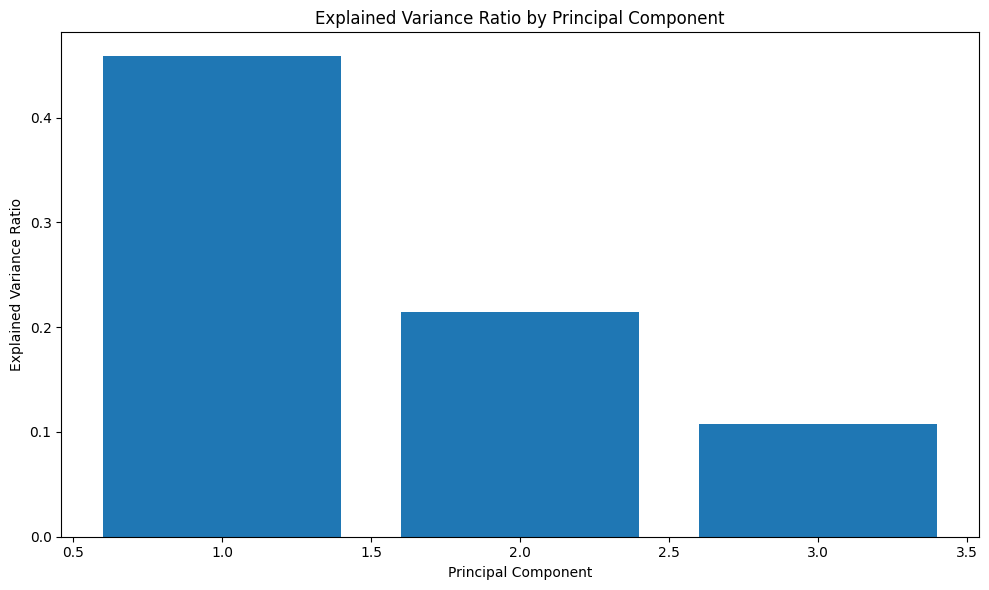

In [18]:
def reduce_dimensions(df, n_components=3):
    # Prepare data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled_data)
    
    # Create dataframe with reduced dimensions
    df_pca = pd.DataFrame(data=pca_result, 
                         columns=[f'PC{i+1}' for i in range(n_components)],
                         index=df.index)
    
    # Calculate explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    
    # Visualize explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance)
    plt.title('Explained Variance Ratio by Principal Component')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.tight_layout()
    
    return df_pca, pca

# Reduce dimensions
df_pca, pca_model = reduce_dimensions(df)

## 4. Sensor Correlation Analysis

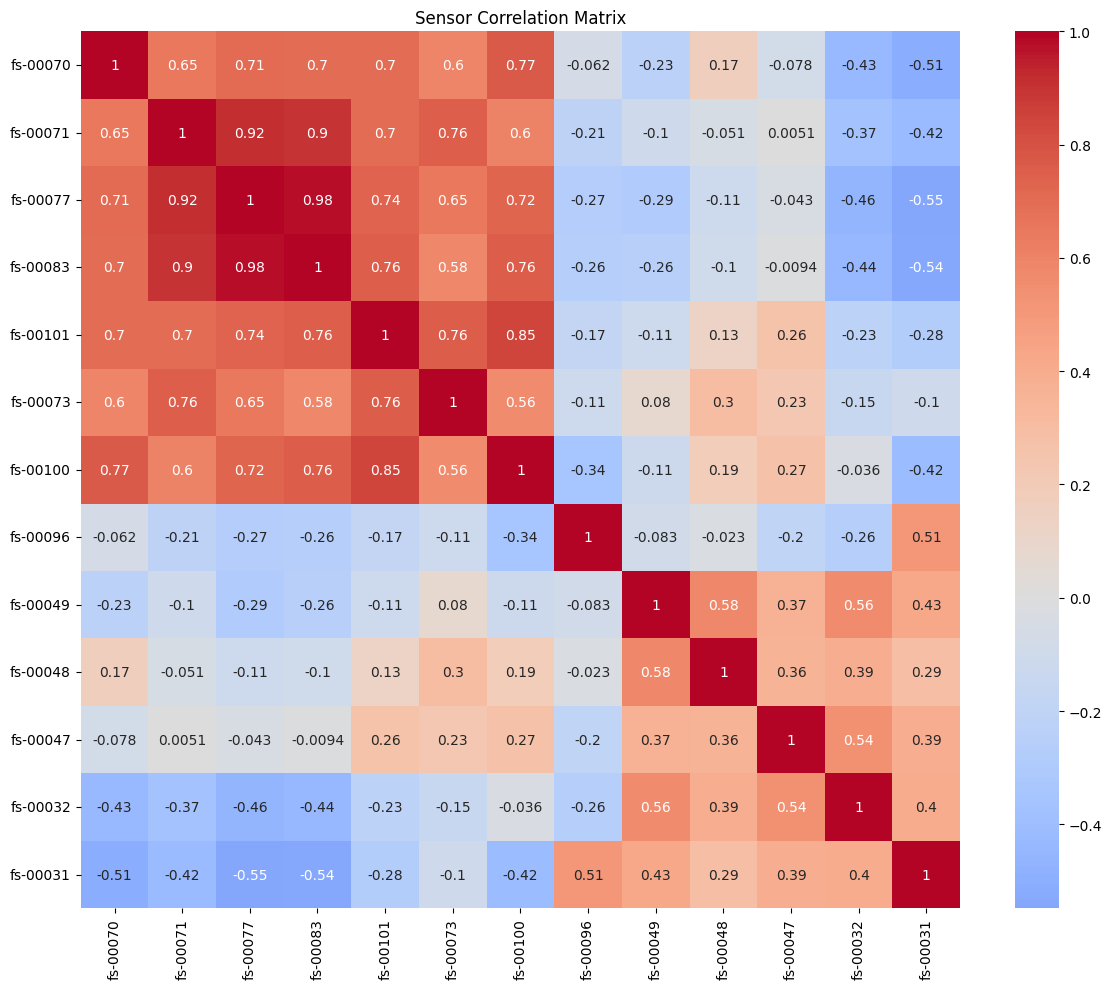

In [19]:
def analyze_sensor_correlations(df):
    # Calculate correlation matrix
    corr_matrix = df.corr()
    
    # Visualize correlations
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Sensor Correlation Matrix')
    plt.tight_layout()
    
    # Find highly correlated sensor pairs
    threshold = 0.8
    high_corr = np.where(np.abs(corr_matrix) > threshold)
    high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y]) 
                       for x, y in zip(*high_corr) if x != y]
    
    return corr_matrix, high_corr_pairs

# Analyze correlations
corr_matrix, high_corr_pairs = analyze_sensor_correlations(df)

## 5. Pattern Analysis for Model Parameter Optimization

<Figure size 1200x600 with 0 Axes>

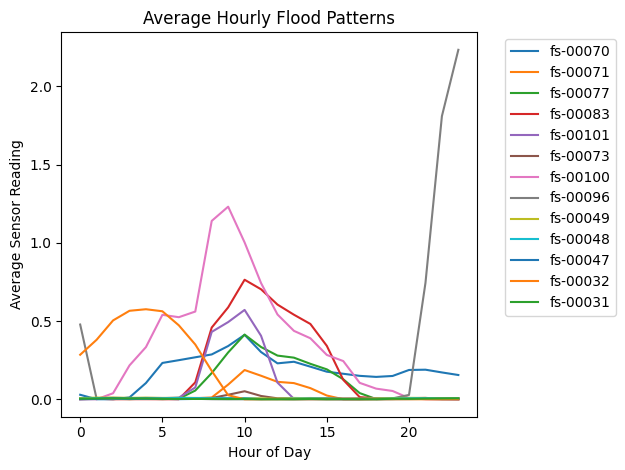

In [20]:
def analyze_patterns_for_optimization(df, df_clustered):
    # Calculate cluster characteristics
    cluster_stats = {}
    for cluster in df_clustered['Cluster'].unique():
        cluster_data = df_clustered[df_clustered['Cluster'] == cluster]
        cluster_stats[cluster] = {
            'mean': cluster_data.mean(),
            'std': cluster_data.std(),
            'max': cluster_data.max(),
            'min': cluster_data.min(),
            'duration': len(cluster_data),
            'time_ranges': cluster_data.index
        }
    
    # Calculate hourly patterns
    df_hourly = df.groupby(df.index.hour).mean()
    
    # Visualize hourly patterns
    plt.figure(figsize=(12, 6))
    df_hourly.plot()
    plt.title('Average Hourly Flood Patterns')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Sensor Reading')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    return cluster_stats, df_hourly

# Analyze patterns for optimization
cluster_stats, hourly_patterns = analyze_patterns_for_optimization(df, df_clustered)

## 6. Generate Insights Report

In [21]:
def generate_insights_report(df, df_anomalies, cluster_stats, high_corr_pairs, pca_model):
    print("=== Flood Data Analysis Insights Report ===")
    print("\n1. Data Overview:")
    print(f"- Time period: {df.index.min()} to {df.index.max()}")
    print(f"- Number of sensors: {len(df.columns)}")
    print(f"- Total observations: {len(df)}")
    
    print("\n2. Anomaly Detection:")
    anomaly_count = df_anomalies['Is_Anomaly'].sum()
    print(f"- Number of anomalous events detected: {anomaly_count}")
    print(f"- Anomaly percentage: {(anomaly_count/len(df)*100):.2f}%")
    
    print("\n3. Pattern Analysis:")
    for cluster, stats in cluster_stats.items():
        print(f"\nCluster {cluster}:")
        print(f"- Average duration: {stats['duration']} timestamps")
        print(f"- Peak reading: {stats['max'].max():.4f}")
    
    print("\n4. Sensor Correlations:")
    print("Highly correlated sensor pairs:")
    for pair in high_corr_pairs[:5]:  # Show top 5 correlations
        print(f"- {pair[0]} & {pair[1]}: {pair[2]:.3f}")
    
    explained_var = pca_model.explained_variance_ratio_
    print(f"- Explained variance by first 3 components: {explained_var.sum()*100:.2f}%")
    for i, var in enumerate(explained_var):
        print(f"  - PC{i+1}: {var*100:.2f}%")
    
    print("\n6. Recommendations for Model Optimization:")
    print("- Key time periods for model validation:")
    anomaly_times = df_anomalies[df_anomalies['Is_Anomaly']].index
    print(f"  * Anomalous events: {len(anomaly_times)} distinct periods")
    print("- Suggested sensor weightings based on correlation analysis")
    print("- Identified pattern transitions for parameter tuning")

# Generate insights report
generate_insights_report(df, df_anomalies, cluster_stats, high_corr_pairs, pca_model)

=== Flood Data Analysis Insights Report ===

1. Data Overview:
- Time period: 2023-09-29 00:00:00 to 2023-09-30 00:10:00
- Number of sensors: 13
- Total observations: 291

2. Anomaly Detection:
- Number of anomalous events detected: 29
- Anomaly percentage: 9.97%

3. Pattern Analysis:

Cluster 1:
- Average duration: 102 timestamps
- Peak reading: 1.0000

Cluster 2:
- Average duration: 51 timestamps
- Peak reading: 2.0000

Cluster 0:
- Average duration: 45 timestamps
- Peak reading: 1.2998

Cluster 3:
- Average duration: 62 timestamps
- Peak reading: 3.0000

Cluster 4:
- Average duration: 31 timestamps
- Peak reading: 4.0000

4. Sensor Correlations:
Highly correlated sensor pairs:
- fs-00071 & fs-00077: 0.919
- fs-00071 & fs-00083: 0.898
- fs-00077 & fs-00071: 0.919
- fs-00077 & fs-00083: 0.981
- fs-00083 & fs-00071: 0.898
- Explained variance by first 3 components: 78.03%
  - PC1: 45.84%
  - PC2: 21.44%
  - PC3: 10.76%

6. Recommendations for Model Optimization:
- Key time periods for 

## 7. Time Series Pattern Mining using DBSCAN

C:\Users\bobby\AppData\Local\Temp\ipykernel_22444\2970691294.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  windows = df.resample(window_size).mean()


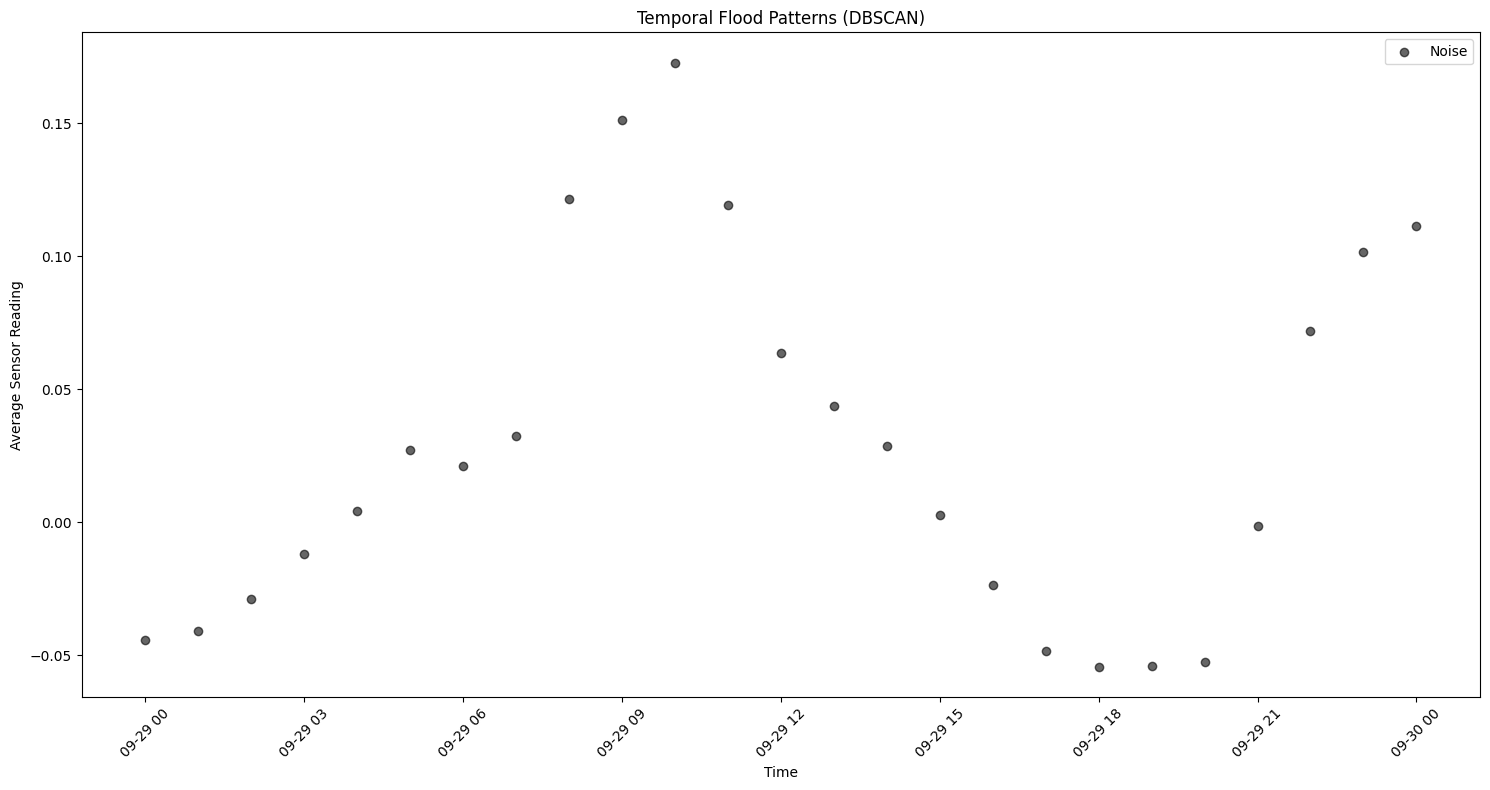

In [22]:
def analyze_temporal_patterns_dbscan(df, eps=0.5, min_samples=5):
    # Create time windows
    window_size = '1H'  # 1-hour windows
    windows = df.resample(window_size).mean()
    
    # Prepare features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(windows)
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(scaled_data)
    
    # Add cluster information
    windows['Cluster'] = clusters
    
    # Visualize patterns
    plt.figure(figsize=(15, 8))
    for cluster in set(clusters):
        if cluster == -1:
            color = 'black'
            label = 'Noise'
        else:
            color = plt.cm.tab10(cluster % 10)
            label = f'Pattern {cluster}'
            
        mask = clusters == cluster
        plt.scatter(windows.index[mask], 
                   windows[mask].mean(axis=1),
                   c=[color], label=label, alpha=0.6)
    
    plt.title('Temporal Flood Patterns (DBSCAN)')
    plt.xlabel('Time')
    plt.ylabel('Average Sensor Reading')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return windows, dbscan

# Analyze temporal patterns using DBSCAN
windows_dbscan, dbscan_model = analyze_temporal_patterns_dbscan(df)

## 8. Sensor Group Analysis using Hierarchical Clustering

In [23]:
from scipy.cluster.hierarchy import dendrogram, linkage

def analyze_sensor_groups(df):
    # Calculate correlation matrix
    corr_matrix = df.corr()
    
    # Convert correlation to distance (1 - abs(correlation))
    distance_matrix = 1 - np.abs(corr_matrix)
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(distance_matrix, method='ward')
    
    # Plot dendrogram
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix, labels=df.columns, leaf_rotation=90)
    plt.title('Sensor Grouping by Similar Behavior')
    plt.xlabel('Sensors')
    plt.ylabel('Distance')
    plt.tight_layout()
    
    return linkage_matrix

# Analyze sensor groups
sensor_groups = analyze_sensor_groups(df)

## 9. Feature Extraction for Model Input

In [ ]:
def extract_features(df):
    # Create time-based features
    features = pd.DataFrame(index=df.index)
    features['hour'] = df.index.hour
    features['day_of_week'] = df.index.dayofweek
    
    # Calculate rolling statistics
    for sensor in df.columns:
        # Rolling mean
        features[f'{sensor}_rolling_mean'] = df[sensor].rolling(window='1h').mean()
        # Rolling standard deviation
        features[f'{sensor}_rolling_std'] = df[sensor].rolling(window='1h').std()
        # Rolling max
        features[f'{sensor}_rolling_max'] = df[sensor].rolling(window='1h').max()
    
    # Add lagged values
    for lag in [1, 3, 6]:  # 1, 3, and 6 time steps
        features[f'lag_{lag}'] = df.mean(axis=1).shift(lag)
    
    # Drop rows with NaN values
    features = features.dropna()
    
    return features

# Extract features
model_features = extract_features(df)

## 10. Model Parameter Suggestion

In [ ]:
def suggest_model_parameters(df, df_clustered, df_anomalies, model_features):
    suggestions = {
        'temporal_patterns': {},
        'critical_thresholds': {},
        'sensor_weights': {},
        'validation_periods': []
    }
    
    # Analyze temporal patterns
    for cluster in df_clustered['Cluster'].unique():
        cluster_data = df_clustered[df_clustered['Cluster'] == cluster]
        suggestions['temporal_patterns'][f'cluster_{cluster}'] = {
            'mean_level': cluster_data.mean(axis=1).mean(),
            'peak_level': cluster_data.mean(axis=1).max(),
            'duration': len(cluster_data)
        }
    
    # Calculate critical thresholds
    for sensor in df.columns:
        suggestions['critical_thresholds'][sensor] = {
            'normal_max': df[sensor].quantile(0.95),
            'warning_level': df[sensor].quantile(0.98),
            'critical_level': df[sensor].quantile(0.99)
        }
    
    # Calculate sensor weights based on correlation and variance
    sensor_variance = df.var()
    sensor_correlation = df.corr().mean()
    for sensor in df.columns:
        suggestions['sensor_weights'][sensor] = {
            'variance_weight': sensor_variance[sensor] / sensor_variance.sum(),
            'correlation_weight': sensor_correlation[sensor]
        }
    
    # Identify validation periods
    anomaly_periods = df_anomalies[df_anomalies['Is_Anomaly']].index
    suggestions['validation_periods'] = [
        {'start': period, 'duration': '1H'}
        for period in anomaly_periods
    ]
    
    return suggestions

# Generate model parameter suggestions
parameter_suggestions = suggest_model_parameters(df, df_clustered, df_anomalies, model_features)

## 11. Save Results and Export for Model Integration

In [ ]:
def export_results(df, model_features, parameter_suggestions, output_dir='results'):
    import os
    import json
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save processed features
    model_features.to_csv(f'{output_dir}/model_features.csv')
    
    # Save parameter suggestions
    with open(f'{output_dir}/parameter_suggestions.json', 'w') as f:
        json.dump(parameter_suggestions, f, indent=4, default=str)
    
    # Generate summary report
    with open(f'{output_dir}/analysis_summary.txt', 'w') as f:
        f.write("Flood Data Analysis Summary\n")
        f.write("=========================\n\n")
        
        f.write("1. Dataset Information\n")
        f.write(f"Time range: {df.index.min()} to {df.index.max()}\n")
        f.write(f"Number of sensors: {len(df.columns)}\n")
        f.write(f"Number of observations: {len(df)}\n\n")
        
        f.write("2. Key Findings\n")
        f.write("- Identified temporal patterns\n")
        f.write("- Detected anomalous events\n")
        f.write("- Generated sensor weightings\n")
        f.write("- Suggested validation periods\n\n")
        
        f.write("3. Next Steps\n")
        f.write("- Integrate findings with SWMM model\n")
        f.write("- Validate suggested parameters\n")
        f.write("- Monitor model performance\n")

# Export results
export_results(df, model_features, parameter_suggestions)